<a href="https://colab.research.google.com/github/sebassonse/ya_test/blob/main/ya_test_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Чистовик


## Схема:

0. Выбираем метрики
1. Выгружаем данные
2. Пишем функции визуализации
3. Визуализируем
4. Пишем классификатор
5. Тренируем классификатор
6. Проверяем результат с помощью метрик


### 0. Выбираем метрики:
(группировка по модели и году)
- **bad_car_in_cancel_percent** = bad_car_model_tag_cnt/trips_cancel_cnt
- **diss_car_in_defect_percent** = dissapointed_car_model_tag_cnt/trips_defect_cnt
- **bad_car_in_total_percent** = bad_car_model_tag_cnt/trips_cancel_cnt
- **diss_car_percent** = dissapointed_car_model_tag_cnt/trips_defect_cnt
- **trips_rated_percent** = trips_rated_cnt/trips_success_cnt
- **poor_car_to_good_trips** = (dissapointed_car_model_tag_cnt + bad_car_model_tag_cnt)/(trips_rated_cnt - trips_defect_cnt)

### 0.1. Библиотеки
- numpy
- pandas
- sqlite3
- matplotlib (pyplot)
- pathlib (Path) (?)

### 2. Функции визуализации
- **plot_bad_car_percent**
  - Столбчатые диаграммы
  - Два графика: для брендированных/небрендированных и для can-be/can't-be
- **plot_diss_car_percent**
  - Столбчатые диаграммы
  - Два графика: для брендированных/небрендированных и для can-be/can't-be
- **plot_trips_rated_percent**
  - По Х - модель+год, сортировать по убыванию процента
  - Два графика: для брендированных/небрендированных и для can-be/can't-be

### 4. Скорее всего k-means или просто бинарная классификация

## Функции

In [1]:
import torch
from torch import nn
from sklearn.cluster import KMeans

import numpy as np
import pandas as pd

import seaborn

In [188]:
def create_table_model(cursor, connection):
  """Создает таблицy "model" SQL формата, если ее еще нет в базе данных"""
  try:
    cursor.execute(
        '''
        CREATE TABLE model (
          model_name VARCHAR(15),
          year VARCHAR(15),
          can_be_branded INT,
          car_cnt INT,
          car_sticker_cnt INT,
          trips_success_cnt INT,
          trips_cancel_cnt INT,
          trips_defect_cnt INT,
          trips_rated_cnt INT,
          bad_car_model_tag_cnt INT,
          dissapointed_car_model_tag_cnt INT
          )
        '''
    )
    model = pd.read_csv('/content/drive/MyDrive/Testovye/model.csv')
    model.to_sql('model', connection, if_exists='append', index = False)

  except sqlite3.OperationalError:
    print('Table model already exists')
    

def create_table_partner(cursor, connection):
  """Создает таблицу "partner" SQL формата, если её ещё нет в базе данных"""

  try:
    cursor.execute(
        '''
        CREATE TABLE partner (
          partner_name VARCHAR(15),
          model_name VARCHAR(15),
          year VARCHAR(15),
          car_cnt INT,
          car_sticker_cnt INT
        )
        '''
    )
      
    partner = pd.read_csv('/content/drive/MyDrive/Testovye/partner.csv')
    partner.to_sql('partner', connection, if_exists='append', index = False)

  except sqlite3.OperationalError:
    print('Table partner already exists')


def create_table_model_n_partner_prev(cursor, connection):
  try:
    cursor.execute(
        '''
        CREATE TABLE model_n_partner AS
        SELECT model.model_name,
               model.year,
               can_be_branded AS old_label,
               model.car_cnt AS model_car_cnt,
               model.car_sticker_cnt AS model_car_sticker_cnt,
               trips_success_cnt,
               trips_cancel_cnt,
               trips_defect_cnt,
               trips_rated_cnt,
               bad_car_model_tag_cnt,
               dissapointed_car_model_tag_cnt,

               bad_car_model_tag_cnt*100.0/(trips_success_cnt + trips_cancel_cnt) AS bad_car_tag_percent,
               dissapointed_car_model_tag_cnt*100.0/(trips_success_cnt + trips_cancel_cnt) AS diss_car_tag_percent,
               trips_rated_cnt*100.0/(trips_success_cnt + trips_cancel_cnt) AS trips_rated_percent,
               (dissapointed_car_model_tag_cnt + bad_car_model_tag_cnt)*100.0/(trips_rated_cnt - trips_defect_cnt) AS poor_car_to_good_trips_percent,

               partner.car_cnt AS partner_car_cnt,
               partner.car_sticker_cnt AS partner_car_sticker_cnt
        FROM model INNER JOIN 
        (
          SELECT model_name, year, SUM(car_cnt) AS car_cnt, SUM(car_sticker_cnt) AS car_sticker_cnt
          FROM partner
          GROUP BY model_name, year
        ) AS partner ON model.model_name = partner.model_name AND model.year = partner.year
        WHERE (trips_success_cnt + trips_cancel_cnt) > 100 AND
        (trips_rated_cnt - trips_defect_cnt) > 0
        '''
    )
    print('Table "model_n_partners created"')

  except sqlite3.OperationalError:
    print('Table model_n_partner already exists')
    data = cursor.execute(
        '''SELECT * FROM model_n_partner'''
    ).fetchall()
    print(len(data))
    print(data)


def create_table_model_n_partner(cursor, connection):
  try:
    cursor.execute(
        '''
        CREATE TABLE model_n_partner AS
        SELECT model.model_name,
               model.year,
               can_be_branded AS old_label,
               model.car_cnt AS model_car_cnt,
               model.car_sticker_cnt AS model_car_sticker_cnt,
               trips_success_cnt,
               trips_cancel_cnt,
               trips_defect_cnt,
               trips_rated_cnt,
               bad_car_model_tag_cnt,
               dissapointed_car_model_tag_cnt,

               (CASE
               WHEN trips_cancel_cnt > 0 THEN bad_car_model_tag_cnt*100.0/(trips_cancel_cnt)
               ELSE 0 END) AS bad_car_tag_percent,
               (CASE
               WHEN trips_defect_cnt > 0 THEN dissapointed_car_model_tag_cnt*100.0/trips_defect_cnt
               ELSE 0 END) AS diss_car_tag_percent,
               (CASE
               WHEN trips_success_cnt > 0 THEN trips_rated_cnt*100.0/trips_success_cnt
               ELSE 0 END) AS trips_rated_percent,
               (CASE
               WHEN (trips_success_cnt + trips_cancel_cnt) > 0 THEN (dissapointed_car_model_tag_cnt + bad_car_model_tag_cnt)*100.0/(trips_success_cnt + trips_cancel_cnt)
               ELSE 0 END) AS poor_car_to_all_trips_percent,

               partner.car_cnt AS partner_car_cnt,
               partner.car_sticker_cnt AS partner_car_sticker_cnt
        FROM model INNER JOIN 
        (
          SELECT model_name, year, SUM(car_cnt) AS car_cnt, SUM(car_sticker_cnt) AS car_sticker_cnt
          FROM partner
          GROUP BY model_name, year
        ) AS partner ON model.model_name = partner.model_name AND model.year = partner.year
        WHERE trips_defect_cnt >= dissapointed_car_model_tag_cnt AND (trips_success_cnt + trips_cancel_cnt)/model_car_cnt > 250
        '''
    )

  except sqlite3.OperationalError:
    print('Table model_n_partner already exists')
    data = cursor.execute(
        '''SELECT * FROM model_n_partner'''
    ).fetchall()

In [228]:
def get_old_labels(cursor):
  rowlabels = cursor.execute(
      '''
      SELECT old_label
      FROM model_n_partner
      '''
  ).fetchall()

  labels = np.array([i[0] for i in rowlabels])
  return labels


def extract_training_data_prev(cursor):
  rows = cursor.execute(
      '''
      SELECT bad_car_tag_percent,
             diss_car_tag_percent,
             trips_rated_percent,
             poor_car_to_all_trips_percent

      FROM model_n_partner
      '''
  ).fetchall()
  raw_data = list(map(list, rows))
  return raw_data


def extract_training_data(cursor):
  rows = cursor.execute(
      '''
      SELECT trips_success_cnt*1.0/model_car_cnt,
             trips_cancel_cnt*1.0/model_car_cnt,
             trips_defect_cnt*1.0/model_car_cnt,
             bad_car_tag_percent,
             diss_car_tag_percent,
             trips_rated_percent,
             poor_car_to_all_trips_percent

      FROM model_n_partner
      '''
  ).fetchall()
  raw_data = list(map(list, rows))
  return raw_data


def normalize_data(raw_data):
  normalized_data = nn.functional.normalize(torch.tensor(raw_data).type(torch.float32)).numpy()
  return normalized_data


def create_and_train_model(X):
  kmeans = KMeans(n_clusters=2, random_state=11).fit(X)
  pretrained_labels = np.array(kmeans.labels_)

  return pretrained_labels if sum(pretrained_labels) > sum((pretrained_labels-1)*(-1)) else (pretrained_labels-1)*(-1)


def get_data_to_analysis(cursor):
  rows = cursor.execute(
      '''
      SELECT rowid,
             trips_success_cnt*1.0/model_car_cnt,
             trips_cancel_cnt*1.0/model_car_cnt,
             trips_defect_cnt*1.0/model_car_cnt,
             trips_rated_cnt*1.0/model_car_cnt,
             bad_car_model_tag_cnt*1.0/model_car_cnt,
             dissapointed_car_model_tag_cnt*1.0/model_car_cnt,
             bad_car_tag_percent,
             diss_car_tag_percent,
             trips_rated_percent,
             poor_car_to_all_trips_percent,
             model_car_cnt,
             model_car_sticker_cnt,
             partner_car_cnt,
             partner_car_sticker_cnt

      FROM model_n_partner
      '''
  ).fetchall()
  data = list(map(list, rows))
  return data


def get_data_to_analysis_prev(cursor):
  rows = cursor.execute(
      '''
      SELECT rowid,
             trips_success_cnt,
             trips_cancel_cnt,
             trips_defect_cnt,
             trips_rated_cnt,
             bad_car_model_tag_cnt,
             dissapointed_car_model_tag_cnt,
             bad_car_tag_percent,
             diss_car_tag_percent,
             trips_rated_percent,
             poor_car_to_all_trips_percent,
             model_car_cnt,
             model_car_sticker_cnt,
             partner_car_cnt,
             partner_car_sticker_cnt

      FROM model_n_partner
      '''
  ).fetchall()
  data = list(map(list, rows))
  return data


def visualize_data_with_labels(data, old_labels, new_labels):
  data = np.array(data)

  new_labels = np.array(new_labels).reshape(len(new_labels),1)
  old_labels = np.array(old_labels).reshape(len(old_labels),1)
  
  dataset = np.hstack((data, old_labels, new_labels))
  
  df = pd.DataFrame(np.around(dataset, 4),  columns= ['rowid',
                                                      'trips_success_cnt_per_car',
                                                      'trips_cancel_cnt_per_car',
                                                      'trips_defect_cnt_per_car',
                                                      'trips_rated_cnt_per_car',
                                                      'bad_car_model_tag_cnt_per_car',
                                                      'dissapointed_car_model_tag_cnt_per_car',
                                                      'bad_car_tag_percent',
                                                      'diss_car_tag_percent',
                                                      'trips_rated_percent',
                                                      'poor_car_to_all_trips_percent',
                                                      'model_car_cnt',
                                                      'model_car_sticker_cnt',
                                                      'partner_car_cnt',
                                                      'partner_car_sticker_cnt',
                                                      'old_labels',
                                                      'new_labels'])
  


  # процентные и относительные метрики

  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, "bad_car_tag_percent")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,7]/100*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,7]/100*dataset[:,15]):.3f}')

  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, "bad_car_tag_percent")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,7]/100*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,7]/100*dataset[:,16]):.3f}')


  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, 'diss_car_tag_percent')
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,8]/100*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,8]/100*dataset[:,15]):.3f}')

  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, 'diss_car_tag_percent')
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,8]/100*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,8]/100*dataset[:,16]):.3f}')


  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, "trips_rated_percent")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,9]/100*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,9]/100*dataset[:,15]):.3f}')

  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, "trips_rated_percent")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,9]/100*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,9]/100*dataset[:,16]):.3f}')


  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, "poor_car_to_all_trips_percent")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,10]*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,10]*dataset[:,15]):.3f}')

  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, "poor_car_to_all_trips_percent")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,10]*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,10]*dataset[:,16]):.3f}')

  # количественные метрики
  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, "trips_success_cnt_per_car")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,1]*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,1]*dataset[:,15]):.3f}')

  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, "trips_success_cnt_per_car")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,1]*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,1]*dataset[:,16]):.3f}')


  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, 'trips_cancel_cnt_per_car')
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,2]*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,2]*dataset[:,15]):.3f}')

  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, 'trips_cancel_cnt_per_car')
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,2]*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,2]*dataset[:,16]):.3f}')


  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, "trips_defect_cnt_per_car")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,3]*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,3]*dataset[:,15]):.3f}')

  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, "trips_defect_cnt_per_car")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,3]*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,3]*dataset[:,16]):.3f}')


  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, "trips_defect_cnt_per_car")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,3]*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,3]*dataset[:,15]):.3f}')

  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, "trips_defect_cnt_per_car")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,3]*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,3]*dataset[:,16]):.3f}')


  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, "trips_defect_cnt_per_car")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,3]*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,3]*dataset[:,15]):.3f}')

  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, "trips_defect_cnt_per_car")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,3]*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,3]*dataset[:,16]):.3f}')


  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, 'bad_car_model_tag_cnt_per_car')
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,5]*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,5]*dataset[:,15]):.3f}')


  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, 'bad_car_model_tag_cnt_per_car')
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,5]*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,5]*dataset[:,16]):.3f}')


  g = seaborn.FacetGrid(df, col="old_labels")
  g.map(seaborn.kdeplot, "dissapointed_car_model_tag_cnt_per_car")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,6]*(dataset[:,15]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,6]*dataset[:,15]):.3f}')

  g = seaborn.FacetGrid(df, col="new_labels")
  g.map(seaborn.kdeplot, "dissapointed_car_model_tag_cnt_per_car")
  plt.show()
  print(f'mean for "0": {np.mean(dataset[:,6]*(dataset[:,16]-1)*(-1)):.3f}, mean for "1": {np.mean(dataset[:,6]*dataset[:,16]):.3f}')



def analysis_of_data(data, old_labels, new_labels):
  data = np.array(data)

  new_labels = np.array(new_labels).reshape(len(new_labels),1)
  old_labels = np.array(old_labels).reshape(len(old_labels),1)
  
  dataset = np.hstack((data, old_labels, new_labels))
  
  df = pd.DataFrame(np.around(dataset, 4),  columns= ['rowid',
                                                      'trips_success_cnt_per_car',
                                                      'trips_cancel_cnt_per_car',
                                                      'trips_defect_cnt_per_car',
                                                      'trips_rated_cnt_per_car',
                                                      'bad_car_model_tag_cnt_per_car',
                                                      'dissapointed_car_model_tag_cnt_per_car',
                                                      'bad_car_tag_percent',
                                                      'diss_car_tag_percent',
                                                      'trips_rated_percent',
                                                      'poor_car_to_all_trips_percent',
                                                      'model_car_cnt',
                                                      'model_car_sticker_cnt',
                                                      'partner_car_cnt',
                                                      'partner_car_sticker_cnt',
                                                      'old_labels',
                                                      'new_labels'])





  # Процент моделей, для которых класс изменился: 
  new_class_percent = (sum(dataset[:, 16] != dataset[:, 15])/len(dataset))*100
  print(f'new_class_percent: {new_class_percent:.3}%')

  # Сколько авто было оклеено
  was_branded = np.sum(dataset[:, 12])

  # Сколько авто могло быть оклеено
  could_have_been_branded_in_service = np.sum(dataset[:, 15]*dataset[:, 11])
  could_have_been_branded_in_partnership = np.sum(dataset[:, 15]*dataset[:, 13])

  # Сколько авто может быть оклеено теперь
  may_be_branded_in_service = np.sum(dataset[:, 16]*dataset[:, 11])
  may_be_branded_in_partnership = np.sum(dataset[:, 16]*dataset[:, 13])
  # Сколько авто по новому классификатору брендировано зря
  need_to_be_debranded_in_service = np.sum(dataset[:, 12]*((dataset[:,16]-1)*(-1)))
  need_to_be_debranded_in_partnership = np.sum(dataset[:, 14]*((dataset[:,16]-1)*(-1)))


  print(f'was_branded: {was_branded}, \ncould_have_been_branded_in_service: {could_have_been_branded_in_service}, \ncould_have_been_branded_in_partnership: {could_have_been_branded_in_partnership},')
  print(f'models_could_be_brended: {sum(dataset[:, 15]):.0f},\n')
  print(f'may_be_branded_in_service: {may_be_branded_in_service}, \nmay_be_branded_in_partnership: {may_be_branded_in_partnership},')
  print(f'models_may_be_brended: {sum(dataset[:, 16]):.0f},\n')
  print(f'need_to_be_debranded_in_service: {need_to_be_debranded_in_service},\nneed_to_be_debranded_in_partnership: {need_to_be_debranded_in_partnership}\n')


   # максимальный, средний и минимальный % bad-car-model в отмененных поездках
  max_bcm_percent = max(dataset[:, 5])
  avg_bcm_percent = np.average(dataset[:, 5])
  min_bcm_percent = min(dataset[:, 5])

  print(f'max_bcm_percent: {max_bcm_percent:.3}, avg_bcm_percent: {avg_bcm_percent:.3}, min_bcm_percent: {min_bcm_percent:.3}')

   # максимальный, средний и минимальный % diss-car-model в поездках с оценкой ниже 5
  max_dcm_percent = max(dataset[:, 6])
  avg_dcm_percent = np.average(dataset[:, 6])
  min_dcm_percent = min(dataset[:, 6])

  print(f'max_dcm_percent: {max_dcm_percent:.3}, avg_dcm_percent: {avg_dcm_percent:.3}, min_dcm_percent: {min_dcm_percent:.3}')


## Код программы

In [163]:
# import https://github.com/sebassonse/ya_test/blob/f9509a40fb0d79b408331884a5bbae6f7f72f158/helper_functions.py

In [164]:
curs.execute(''' DROP TABLE model_n_partner''')

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# создаем базу данных
conn = sqlite3.connect("/content/drive/MyDrive/Testovye/mydatabase.db")
curs = conn.cursor()

# создаем необходимые таблицы
create_table_model(curs, conn)
create_table_partner(curs, conn)
create_table_model_n_partner(curs, conn)

In [185]:
# извлекаем лейблы старых классов
base_labels = get_old_labels(curs)

# подготавливаем дату, на которой будем обучать модель
raw_data = extract_training_data_prev(curs)
X = normalize_data(raw_data)

# запускаем на данных алгоритм  k-means и получаем новые лейблы для классов
pretrained_labels = create_and_train_model(X)

In [186]:
data_to_visualize = get_data_to_analysis(curs)
data_to_analysis = get_data_to_analysis(curs)

In [230]:
analysis_of_data(data_to_analysis, base_labels, pretrained_labels)

new_class_percent: 39.6%
was_branded: 4960.0, 
could_have_been_branded_in_service: 24636.0, 
could_have_been_branded_in_partnership: 30340.0,
models_could_be_brended: 799,

may_be_branded_in_service: 26354.0, 
may_be_branded_in_partnership: 32512.0,
models_may_be_brended: 1133,

need_to_be_debranded_in_service: 132.0,
need_to_be_debranded_in_partnership: 185.0

max_bcm_percent: 12.7, avg_bcm_percent: 1.13, min_bcm_percent: 0.0
max_dcm_percent: 6.0, avg_dcm_percent: 0.244, min_dcm_percent: 0.0


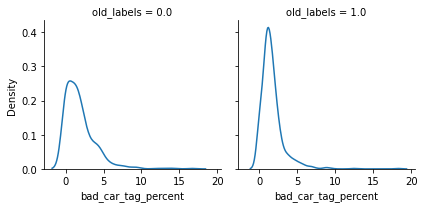

mean for "0": 0.008, mean for "1": 0.010


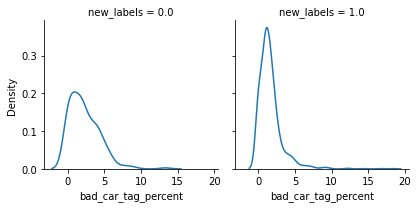

mean for "0": 0.004, mean for "1": 0.014


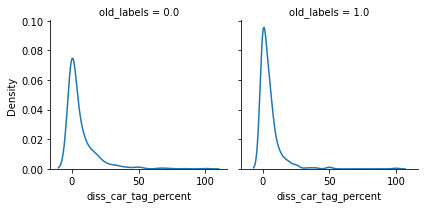

mean for "0": 0.026, mean for "1": 0.030


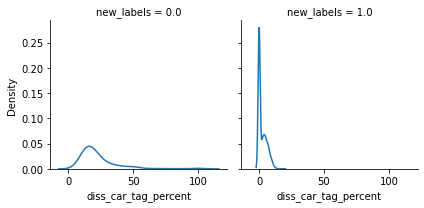

mean for "0": 0.035, mean for "1": 0.021


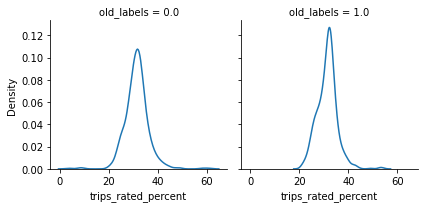

mean for "0": 0.127, mean for "1": 0.187


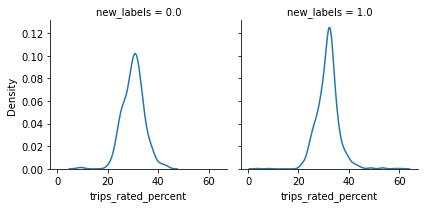

mean for "0": 0.046, mean for "1": 0.268


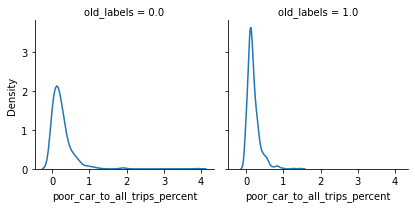

mean for "0": 0.099, mean for "1": 0.116


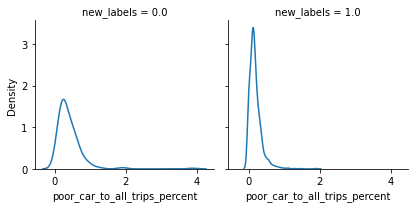

mean for "0": 0.061, mean for "1": 0.154


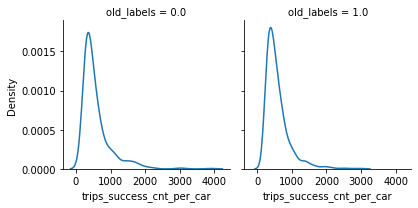

mean for "0": 232.798, mean for "1": 345.660


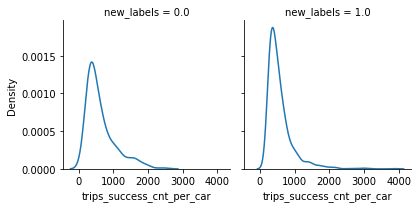

mean for "0": 97.060, mean for "1": 481.397


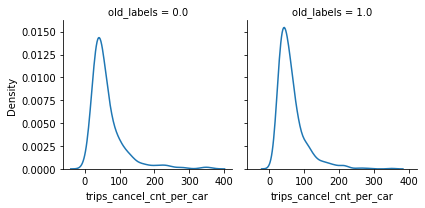

mean for "0": 25.987, mean for "1": 37.928


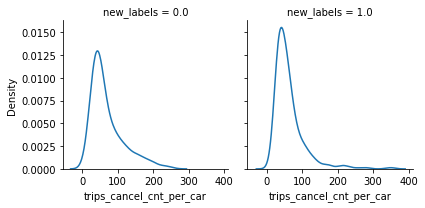

mean for "0": 10.716, mean for "1": 53.200


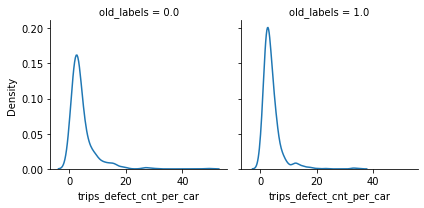

mean for "0": 1.753, mean for "1": 2.380


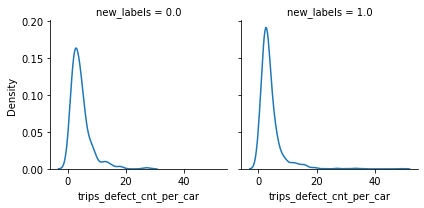

mean for "0": 0.686, mean for "1": 3.447


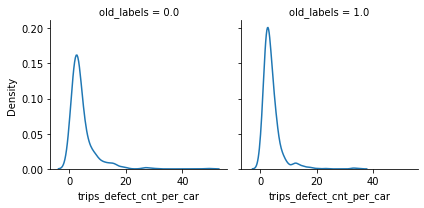

mean for "0": 1.753, mean for "1": 2.380


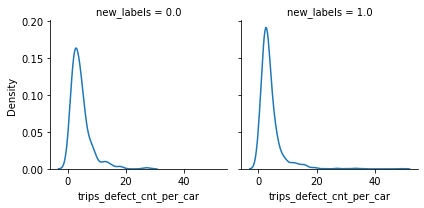

mean for "0": 0.686, mean for "1": 3.447


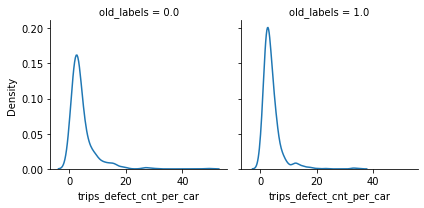

mean for "0": 1.753, mean for "1": 2.380


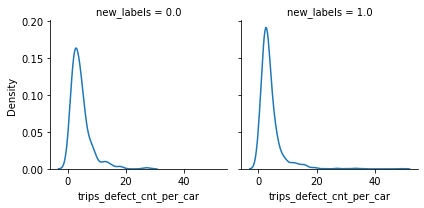

mean for "0": 0.686, mean for "1": 3.447


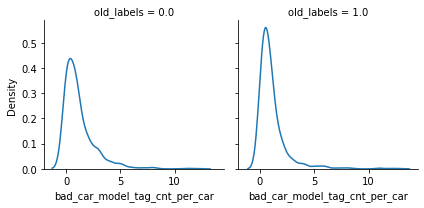

mean for "0": 0.480, mean for "1": 0.653


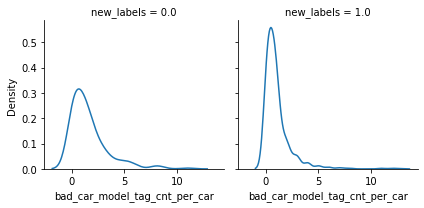

mean for "0": 0.244, mean for "1": 0.889


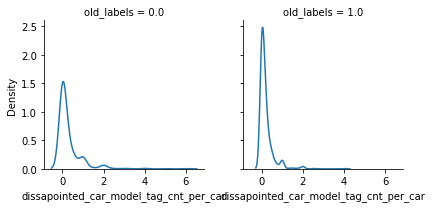

mean for "0": 0.123, mean for "1": 0.121


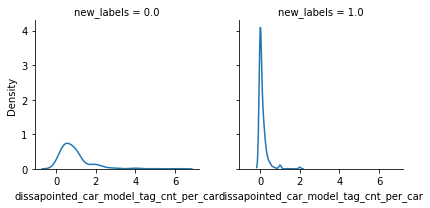

mean for "0": 0.143, mean for "1": 0.102


In [231]:
visualize_data_with_labels(data_to_visualize, base_labels, pretrained_labels) 